In [41]:
# Data Management
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from pandas_datareader.data import DataReader
import yfinance as yf

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Graphing
import matplotlib.pyplot as plt

In [42]:
# Remove Unwanted Warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None  # ignore column assingment tecnique warning (wants to use .iloc)

### Initial Data Extraction


In [43]:
# TIMEFRAME
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "^VIX"




# FETCH USING YAHOO FINANCE 
# df = yf.download(symbol ,  start_date , end_date )


tickerData = yf.Ticker(symbol)
df = tickerData.history(period='1d', start=start_date, end=end_date)


# REFINE COLUMNS
df = df[["High" , "Low" ,  "Open", "Close" , "Volume"]]


## Feature Engineering

In [44]:
# Add Technical Analysis Columns
df = add_all_ta_features( 
    df , open="Open", high="High", low="Low", close="Close", volume="Volume" , fillna=True
 )

print(f"Rows (dates): {df.shape[0]}\nColumns (technical analysis): {df.shape[1]}")

Rows (dates): 1362
Columns (technical analysis): 91


In [45]:
# Find Non-Stationary Columns 
non_stationaries = []
columns_with_constants = []

for col in df.columns:
    # Check if column values are all the same
    if df[col].nunique() <= 1:
        columns_with_constants.append(col)
        print(f"Skipping constant column: {col}")
        continue

    # Find variance in column numbers
    dftest = adfuller(df[col].values)
    
    # Get p-value
    p_value = dftest[1]
    
    # Perform t-test
    t_test = dftest[0] < dftest[4]["1%"]
    
    # Check if non stationary
    if p_value > 0.05  or not t_test:
        non_stationaries.append(col)

print(f"Non-Stationaries found:  {len(non_stationaries)}")


Skipping constant column: Volume
Skipping constant column: volume_adi
Skipping constant column: volume_obv
Skipping constant column: volume_cmf
Skipping constant column: volume_fi
Skipping constant column: volume_em
Skipping constant column: volume_sma_em
Skipping constant column: volume_vpt
Skipping constant column: volume_vwap
Skipping constant column: volume_mfi
Skipping constant column: volume_nvi
Skipping constant column: momentum_pvo
Skipping constant column: momentum_pvo_signal
Skipping constant column: momentum_pvo_hist
Non-Stationaries found:  15


In [46]:
# Convert Non-Stationaries into Stationaries
df_stationary = df.copy()


# Find all Nonstationaries  &  Turn them into percent change instead
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()  


#Remove because First column is the names thus [0,0,0,0...] 
df_stationary = df_stationary.iloc[1:]

In [47]:
# Remove if Column has any NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list , inplace=True)

In [48]:
# Handle Infinity Values
df_stationary = df_stationary.replace( [np.inf , -np.inf] , 0 )

print(df_stationary.shape)

(1361, 91)


# Scaling Data

In [49]:
# Set Target (for supervised ML later on)

# checks if the 'Close' price for the next day (df_stationary["Close"].shift(-1)) is greater than the 'Close' price for the current day (df_stationary["Close"]).
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Close"].shift(-1) > df_stationary["Close"] , "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [50]:
# Split Target from FeaturSet
x = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [51]:
# Feature Scaling
df_scaled = df_stationary.copy()
x_feature_scaled = StandardScaler().fit_transform(x)

# Train Test Split

In [52]:
x_train , x_test ,  y_train , y_test = train_test_split(x_feature_scaled , y , test_size=0.7, random_state=42)

# Unsupervised ML - PCA Dimentionality Reduction

In [53]:
# PCA 

# Set the number of principal components (columns) to retain
n_components = 10

# Initialize a PCA model with the specified number of components
pca = PCA(n_components=n_components)

# Fit the PCA model to the training data, which involves calculating the mean, variance, and principal components
pca_result = pca.fit(x_train)

# Transform the training data into the PCA space, resulting in a dataset with the same number of rows but only `n_components` columns
x_train_pca = pca_result.transform(x_train)

# Transform the testing data into the same PCA space as the training data, so that the model can make predictions on the test data using the same principal components
x_test_pca = pca_result.transform(x_test)

### DISPLAY REDUCED & COMBINED COLUMNS
- all 90 technical analysis columns had PCA applied onto them and these are the combined metrics simplified into 5 columns

In [54]:
# Calculate the variance explained by Principle Components
print("Each New Columns Variance\n" , pca.explained_variance_ratio_)
print("\nTotal Variance from original data: " , round(sum(list(pca.explained_variance_ratio_)) * 100 , 2 ))

Each New Columns Variance
 [0.39413577 0.18823977 0.08440911 0.04866785 0.03309717 0.02531148
 0.02407593 0.02108722 0.01532223 0.01384067]

Total Variance from original data:  84.82


In [55]:
# Create the dataframe for these simplified columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")


# DATAFRAME 
df_pca = pd.DataFrame(data=x_train_pca, columns=pca_cols)

df_pca

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9
0,-7.428185,0.239691,-0.747321,0.098110,4.301372,0.656221,-2.661056,7.564212,-0.304279,2.206170
1,-4.620445,-0.413357,-2.618780,0.739566,0.948161,0.889216,-0.081782,0.933965,-0.589720,-0.681244
2,-1.880299,4.574817,-1.048556,0.693949,0.810126,0.591125,-1.910371,-0.314199,-1.371555,0.976659
3,2.181919,-4.695088,-0.621390,0.908569,-1.699958,-0.904015,0.161863,0.631955,-0.387625,-0.593812
4,-4.806659,0.841365,2.434233,-0.778548,1.897885,0.958343,0.445741,-0.700841,-0.729185,-0.282219
...,...,...,...,...,...,...,...,...,...,...
403,11.241388,-4.601692,3.751535,4.299053,0.352996,2.785318,-0.701819,-0.221056,0.209232,0.842144
404,-3.522319,-0.199351,-0.399824,-0.023037,0.598069,0.494369,-0.431783,-0.066705,-0.834241,-0.507511
405,6.392239,1.466891,2.214035,-1.565129,-0.208694,-1.100428,-0.959668,0.063779,1.059218,0.040500
406,-7.090165,3.602124,3.318682,-1.520469,2.323056,0.776114,-1.071731,-0.699290,-1.772347,-0.042511


#### Visualize PCA
- comparing two PCA (dimention reduced) columns

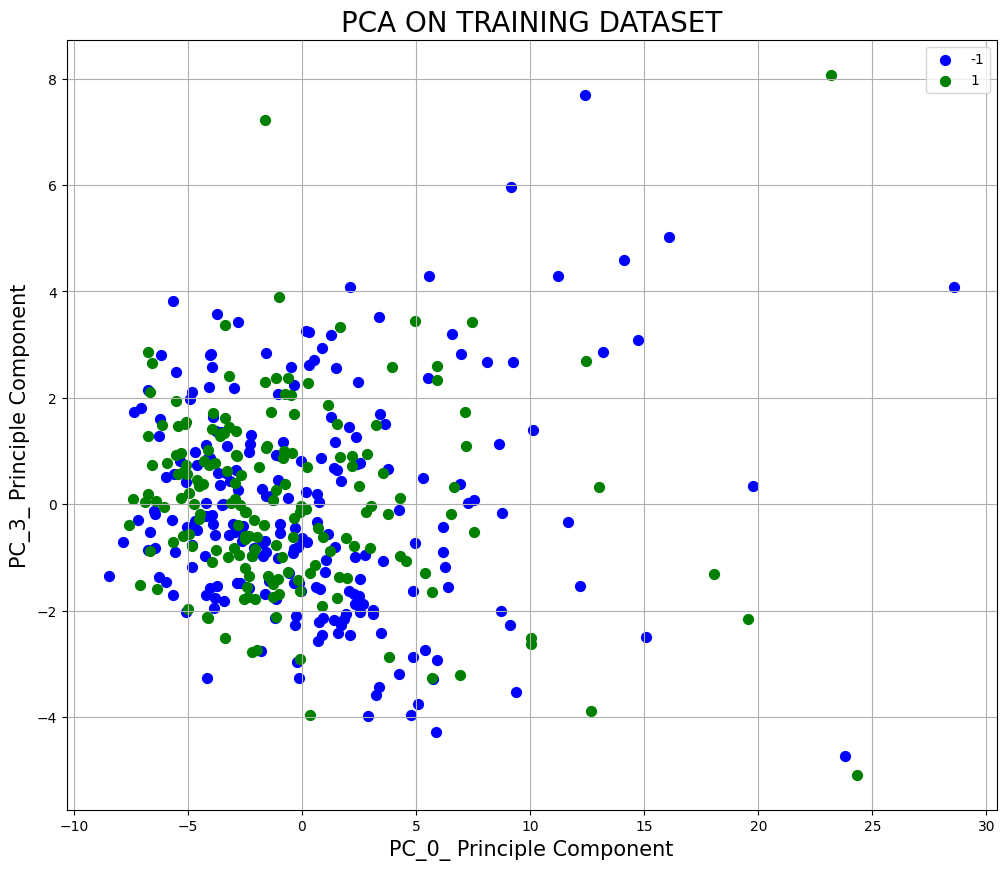

In [56]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)

col_1 = "PC_0"
col_2 = "PC_3"

ax.set_xlabel(f"{col_1}_ Principle Component" , fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component" , fontsize=15)
ax.set_title("PCA ON TRAINING DATASET", fontsize=20)



targets = [-1,1]
colors = ["b","g"]

for target , color in zip(targets,colors):
    indicies_to_keep = y_train == target
    indicies_to_keep = list(indicies_to_keep)
    ax.scatter(
        df_pca.loc[indicies_to_keep , col_1] ,
        df_pca.loc[indicies_to_keep , col_2] ,
        c=color , s=50
    )

ax.legend(targets)
ax.grid()

# Supervised ML - Random Forest Classifiers

In [57]:
classifier = RandomForestClassifier(n_estimators=12 , max_depth=2 , random_state=0)
classifier.fit(x_train , y_train)


# Use the trained classifier to make predictions on the test feature data (x_test)
y_prediction = classifier.predict(x_test)


# Calculate Accuracy and Precision of Y-axis Prediction
accuracy = accuracy_score(y_test , y_prediction)
precision = precision_score(y_test,y_prediction)


print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.5603357817418678
Test Precision: 0.5185185185185185


In [58]:
y_pred_proba = classifier.predict_proba(x_test)
y_pred_proba

array([[0.43364483, 0.56635517],
       [0.65980578, 0.34019422],
       [0.51314651, 0.48685349],
       ...,
       [0.55865665, 0.44134335],
       [0.63619623, 0.36380377],
       [0.46541144, 0.53458856]])

In [59]:
# Test for overfitting
train_scores = list()
test_scores  = list()

values = [i for i in range(1,200)]

for i in values:
    classifier = RandomForestClassifier(n_estimators=i , max_depth=2 , random_state=0)
    classifier.fit(x_train , y_train)

    # Training Data
    y_train_pred = classifier.predict(x_train)
    accuracy_train = accuracy_score(y_train , y_train_pred)
    train_scores.append(accuracy_train)

    # Test Data
    y_test_pred = classifier.predict(x_test)
    accuracy_test = accuracy_score(y_test , y_test_pred)
    test_scores.append(accuracy_test)

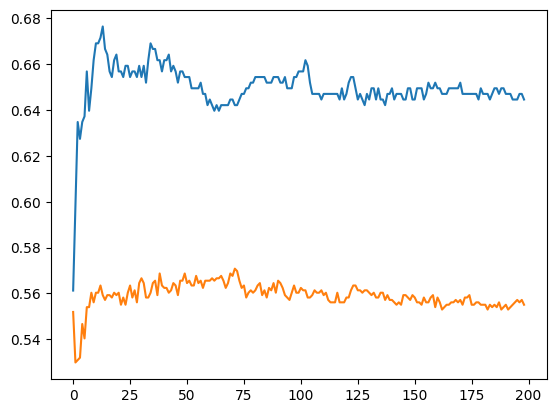

In [60]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()